# Predicting Tanzania Water Pumps Functionality

**Author : Edwin Maina**



## Business Understanding

Access to clean  water is a fundamental human need and a key for public health, economic development, and social well-being. 

In Tanzania, communities heavily rely on water wells for their daily water supply. However, many of these water points become non-functional over time due to poor maintenance, environmental conditions, or inadequate infrastructure.

This project aims to build a predictive models to assess the functionality status of water wells in Tanzania. The models will help stakeholders prioritize maintenance efforts, allocate resources more effectively, and ensure that water wells remain operational for the communities that depend on them.


### Business Problem

Tanzania's water supply system is characterized by frequent water pump breakdowns resulting from lack of proper maintenance and inefficient management. This leads to disruptions in water supply, exacerbating the acute shortage of clean water and subsequent socio-economic losses.

The government of Tanzania, in collaboration with NGOs and partner organizations, aims to enhance access to clean water by improving the maintenance and functionality of water wells across the country. To achieve this, water point sustainability risk levels across the supply system need to be projected by learning from current point profiles to guide stakeholders' decisions through highlighting:

  - Most dilapidated wells that should be prioritized for maintenance, repairs, or rehabilitation.
  - Sites to be earmarked for future wells.
  - Data-driven recommendations that are responsive to stakeholders' needs and actionable guide improve management practices and water accessibility.


### Importing Required Libraries

In [88]:
# importing pandas for data wrangling and manipulation
import pandas as pd
import numpy as np

# importing matplotlib and seaborn for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config inlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import random

### loading the Datasets

In [89]:
training_values = pd.read_csv('Trainig_set_values.csv')
training_values.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [90]:
training_labels = pd.read_csv('Training_set_labels.csv')
training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [91]:
test_values = pd.read_csv('Test_set_values.csv')
test_values.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


### Merging Training values and labels dataset

In [92]:

# Merging the training values with the labels to create a complete training dataset
train_data = pd.merge(training_values, training_labels, on="id")

train_data.info()

train_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [93]:
train_data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [94]:
# unique values in each column
{column: train_data[column].nunique() for column in train_data.columns}
    #Observations:

{'id': 59400,
 'amount_tsh': 98,
 'date_recorded': 356,
 'funder': 1897,
 'gps_height': 2428,
 'installer': 2145,
 'longitude': 57516,
 'latitude': 57517,
 'wpt_name': 37400,
 'num_private': 65,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'region_code': 27,
 'district_code': 20,
 'lga': 125,
 'ward': 2092,
 'population': 1049,
 'public_meeting': 2,
 'recorded_by': 1,
 'scheme_management': 12,
 'scheme_name': 2696,
 'permit': 2,
 'construction_year': 55,
 'extraction_type': 18,
 'extraction_type_group': 13,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment': 7,
 'payment_type': 7,
 'water_quality': 8,
 'quality_group': 6,
 'quantity': 5,
 'quantity_group': 5,
 'source': 10,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'waterpoint_type_group': 6,
 'status_group': 3}

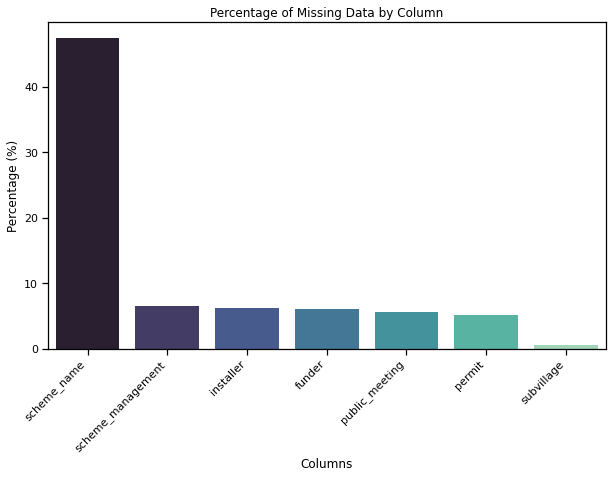

scheme_name          47.417508
scheme_management     6.526936
installer             6.153199
funder                6.119529
public_meeting        5.612795
permit                5.144781
subvillage            0.624579
dtype: float64

In [95]:
# Checking the percentage of missing values in each column
missing_data = train_data.isnull().mean() * 100

# Filtering columns with missing values only
missing_columns = missing_data[missing_data > 0].sort_values(ascending=False)

# Visualizing 
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_columns.index, y=missing_columns.values, palette='mako')
plt.title('Percentage of Missing Data by Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.show()

missing_columns


## Data Cleaning

### Dropping Unnecessary Columns

I dropped the following columns as they were redundant as they represent the same thing or irrelevant  for the objective of our model:

- wpt_name: Name of the waterpoint (not relevant for our analysis).
- num_private: Number of private pumps.
- subvillage: Subvillage location.
- district_code: District code.
- region (redundant with region code)
- lga: Local government authority .
- ward: Administrative ward .
- public_meeting.
- recorded_by:person recording the data 
- scheme_name: Name of the waterpoint scheme .
- scheme_management
- extraction_type: Type of extraction (redundant with 'extraction_type_group').
- extraction_type_group: Grouped extraction type (redundant with 'extraction_type').
- management_group: Grouped management type (redundant with 'management').
- payment: Payment method (redundant with 'payment_type').
- quality_group: Grouped water quality (redundant with 'water_quality').
- quantity_group: Grouped water quantity (redundant with 'quantity').
- source: Source type (redundant with 'source_type').
- waterpoint_type_group: Grouped waterpoint type (redundant with 'waterpoint_type').

In [96]:
def irrelevant_columns(data, columns):
    """
    Function for removing columns that either represent the same thing or are irrelevant to the model that will be built
    """                   
    cleaned_df = data.drop(columns, axis=1)
    return cleaned_df

In [97]:
irrelevant_columns1 = ['wpt_name', 'num_private', 'subvillage', 'region', 'lga',\
                       'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', \
                        'extraction_type_group', 'management_group','payment', 'quality_group', 'quantity_group', 'source', 'waterpoint_type_group'] 

train_data = irrelevant_columns(train_data, irrelevant_columns1)
train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region_code,...,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,11,...,1999,gravity,vwc,annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,20,...,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,21,...,2009,gravity,vwc,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,90,...,1986,submersible,vwc,never pay,soft,dry,borehole,groundwater,communal standpipe multiple,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,18,...,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [98]:
{column: train_data[column].nunique() for column in train_data.columns}

{'id': 59400,
 'amount_tsh': 98,
 'date_recorded': 356,
 'funder': 1897,
 'gps_height': 2428,
 'installer': 2145,
 'longitude': 57516,
 'latitude': 57517,
 'basin': 9,
 'region_code': 27,
 'district_code': 20,
 'population': 1049,
 'permit': 2,
 'construction_year': 55,
 'extraction_type_class': 7,
 'management': 12,
 'payment_type': 7,
 'water_quality': 8,
 'quantity': 5,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'status_group': 3}

In [99]:
train_data.duplicated().sum()

0

In [100]:
train_data.isnull().sum()


id                          0
amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
basin                       0
region_code                 0
district_code               0
population                  0
permit                   3056
construction_year           0
extraction_type_class       0
management                  0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

In [101]:
train_data.describe()

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,99.000000,80.000000,30500.000000,2013.000000


## EXPLORATORY DATA ANALYSIS

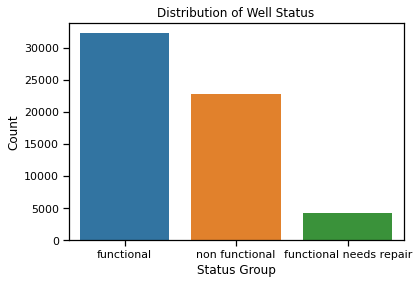

In [102]:
# Checking the distribution of the target variable 'status_group'
target_distribution = train_data['status_group'].value_counts(normalize=True) * 100

# Visualizing the distribution of the target variable
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=train_data, x='status_group', order=train_data['status_group'].value_counts().index, )
plt.title('Distribution of Well Status')
plt.ylabel('Count')
plt.xlabel('Status Group')
plt.show()

#### **2. Map of water well location and the functionality status of the water pumps**


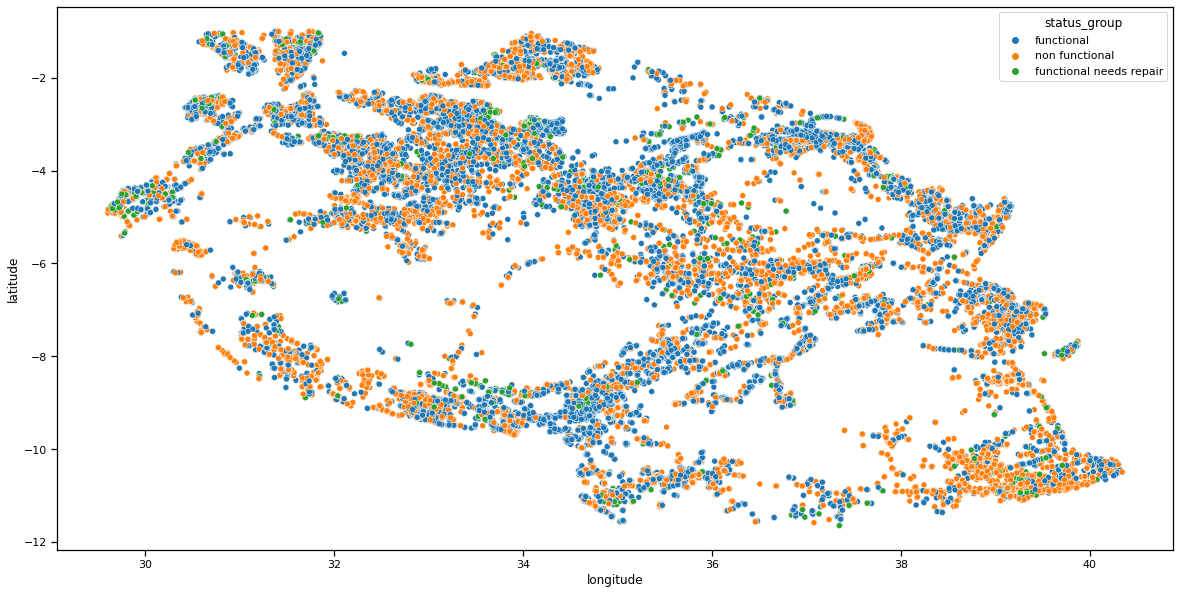

In [103]:
fig, ax  = plt.subplots(figsize=(20,10))
loc_data = train_data.loc[(train_data.longitude>0) & (train_data.latitude<0)]
sns.scatterplot(data=loc_data, x="longitude", y="latitude", hue="status_group", ax=ax);

        

**Observations:**
Across most of the country, the functionality status of water pumps appears evenly distributed. However, the Southeastern and Western regions demonstrate a significant concentration of non-functional water pumps. Additionally, certain geographical areas show a complete absence of water pumps, which are likely uninhabited zones or poorly developed.

#### **3. Effect of the water point type on the functionality status of water pumps**

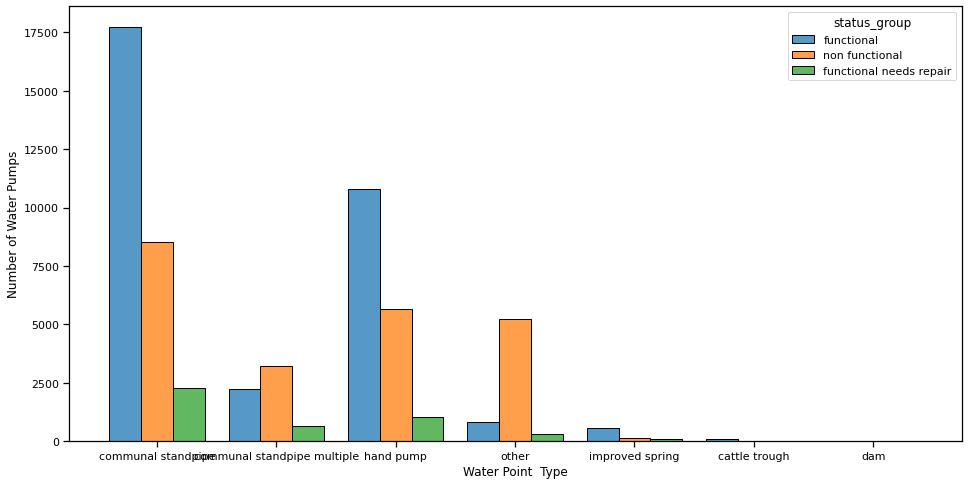

In [104]:
fig, ax  = plt.subplots(figsize=(16,8))
sns.histplot(data=train_data, x="waterpoint_type", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel('Water Point  Type')
ax.set_ylabel('Number of Water Pumps');



**Observations:**

Communal standpipes represent the dominant water point type with more functional pumps, with the 'other' category water points exhibiting a higher proportion of non-functional pumps compared to functional ones.

 #### **4. Functionality status of water pumps by the construction year**

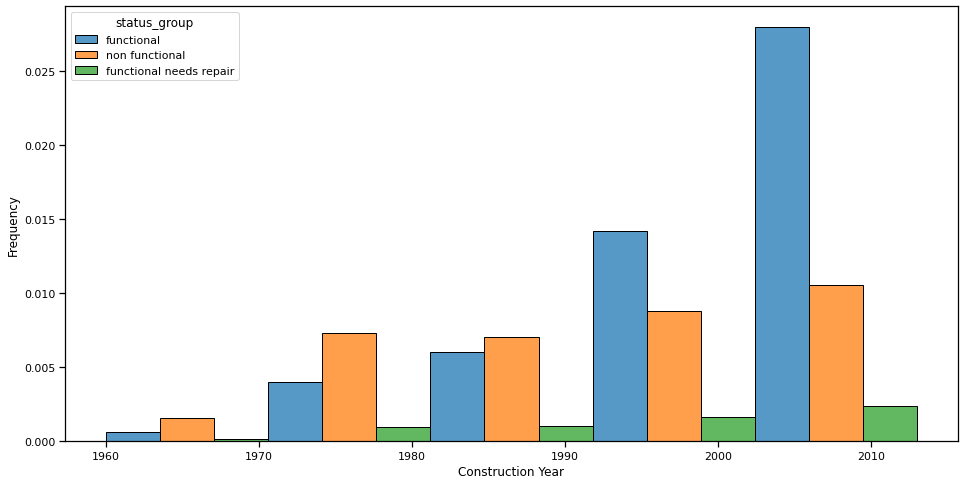

In [105]:
year = train_data[train_data['construction_year'] >0]
fig, ax  = plt.subplots(figsize=(16,8))
sns.histplot(data=year, x='construction_year', stat='density', hue='status_group', multiple='dodge',bins=5, ax=ax)
ax.set_xlabel('Construction Year')
ax.set_ylabel('Frequency');


The analysis reveals that water pumps constructed in 1990 and earlier have a higher proportion of pumps requiring repair compared to functional pumps. The data demonstrates older water pump infrastructure is more in need of maintenance, with the number of pumps needing repair outweighing those in good working condition.

#### **5. Water quantity in a well in relation to the functionality of the water pumps**

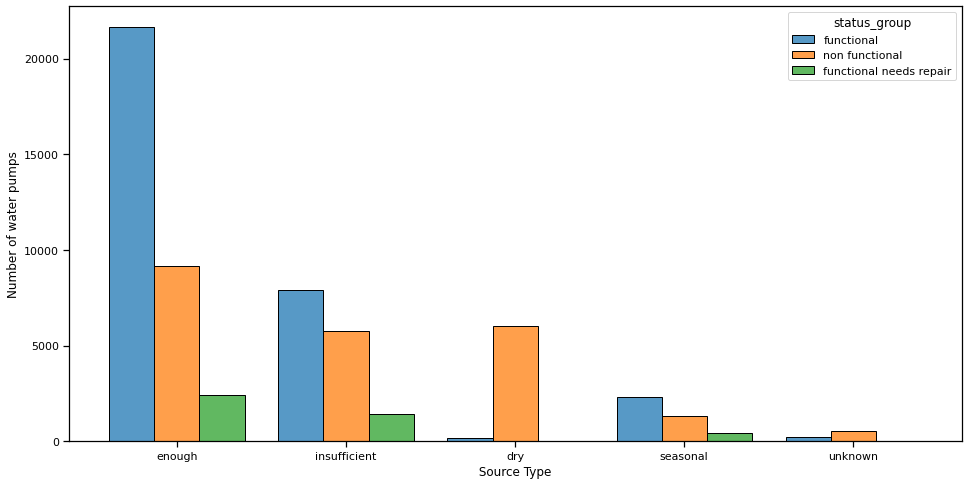

In [106]:
fig, ax  = plt.subplots(figsize=(16,8))
sns.histplot(data=train_data, x="quantity", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel(' Source Type ')
ax.set_ylabel('Number of water pumps');

 In regions with water present, functional water pumps are more prevalent than non-functional ones. While, in dry wells or areas without water, the situation is that non-functional water pumps significantly outnumber the functional ones.

#### **6. Water source type effect on the functionality of the water pumps**

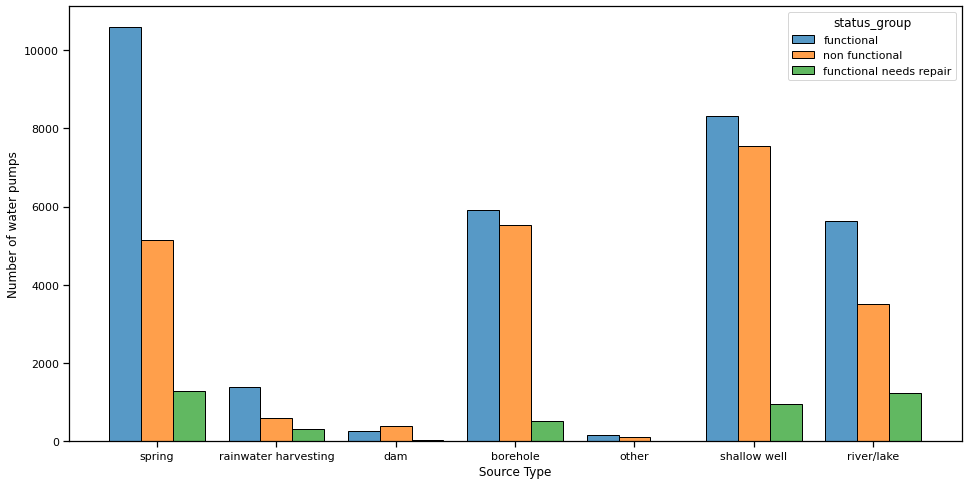

In [107]:
fig, ax  = plt.subplots(figsize=(16,8))
sns.histplot(data=train_data, x="source_type", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel(' Source Type ')
ax.set_ylabel('Number of water pumps');


**observations:**

 Among the six water types, dams are the only category where non-functional pumps are more common, while all other water types have more functional pumps than non-functional ones

#### **7. Visualizing the effect of water quality on the functionality status of the water pumps**

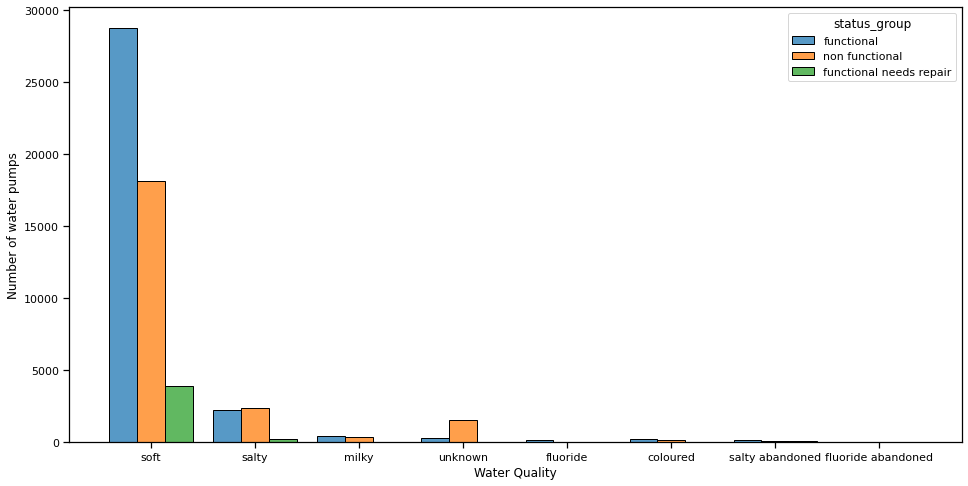

In [108]:
fig, ax  = plt.subplots(figsize=(16,8))
sns.histplot(data=train_data, x="water_quality", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel("Water Quality")
ax.set_ylabel("Number of water pumps");

**Observations**

Water Quality: Most of the water pumps provide soft water.

Functional Pumps: More pumps in areas with soft water are functional compared to those in areas with salty water.

Non-Functional Pumps: Slightly more pumps in areas with salty water are non-functional compared to functional ones.

Repairs Needed: A small number of pumps, regardless of water quality, are functional but require repairs.

 #### **8. Influences of the payment type on the functionality status of the water pumps**

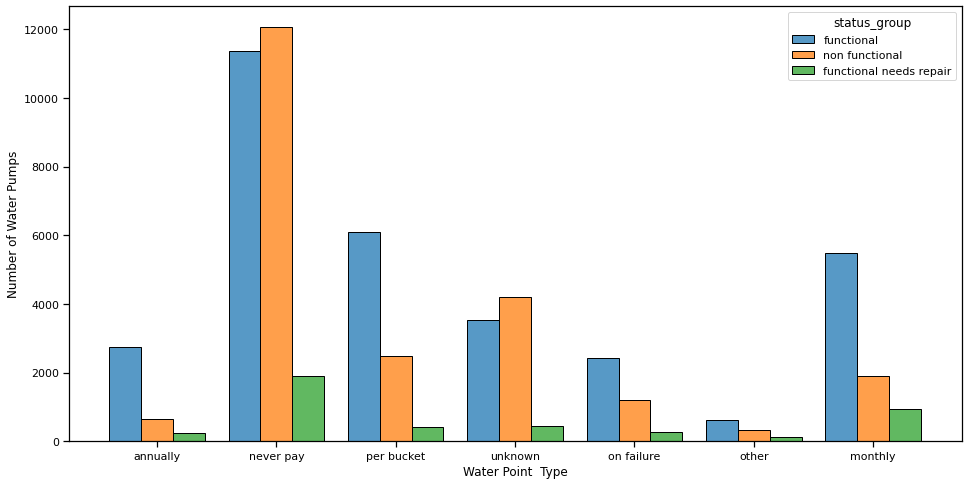

In [109]:
pop_status = train_data.groupby(['status_group'])['population'].sum()

fig, ax  = plt.subplots(figsize=(16,8))
sns.histplot(data=train_data, x="payment_type", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel('Water Point  Type')
ax.set_ylabel('Number of Water Pumps');

 In the "Never Pay" category and the "Unknown" payment type, non-functional water pumps outnumber functional ones. 
 
 For water pumps associated with payment, the majority are functional, with working pumps significantly outweighing non-functional pumps.

## DATA PREPARATION

In [110]:
print(train_data.groupby('payment_type')['status_group'].value_counts(normalize=True))

payment_type  status_group           
annually      functional                 0.752334
              non functional             0.179846
              functional needs repair    0.067820
monthly       functional                 0.660482
              non functional             0.227831
              functional needs repair    0.111687
never pay     non functional             0.475856
              functional                 0.448911
              functional needs repair    0.075233
on failure    functional                 0.620593
              non functional             0.308636
              functional needs repair    0.070772
other         functional                 0.579696
              non functional             0.308349
              functional needs repair    0.111954
per bucket    functional                 0.677796
              non functional             0.276683
              functional needs repair    0.045520
unknown       non functional             0.514527
            

In [111]:
train_data.isnull().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
basin                       0
region_code                 0
district_code               0
population                  0
permit                   3056
construction_year           0
extraction_type_class       0
management                  0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

In [112]:
# Function to identify missing columns
def is_missing(data):
    return data.columns[data.isin([0, -2.000000e-08]).any()]


In [113]:
# 1. Handling High Cardinality Columns

#top N frequent values, grouping the rest under "other".
    

def reduce_high_cardinality(data, column, top_n=4):
    
    top_values = data[column].value_counts().nlargest(top_n).index
    data[column] = data[column].apply(lambda x: x if x in top_values else 'other')
    return data

# Reduce high cardinality in 'funder' and 'installer'
train_data = reduce_high_cardinality(train_data, 'funder', top_n=4)
train_data = reduce_high_cardinality(train_data, 'installer', top_n=4)


print("Reduced 'funder' unique values:", train_data['funder'].nunique())
print(train_data['funder'].value_counts())

print("\nReduced 'installer' unique values:", train_data['installer'].nunique())
print(train_data['installer'].value_counts())



Reduced 'funder' unique values: 5
other                     43626
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
Name: funder, dtype: int64

Reduced 'installer' unique values: 5
other         37907
DWE           17402
Government     1825
RWE            1206
Commu          1060
Name: installer, dtype: int64


In [114]:
# 2. Handling Missing Values

#Replace missing values in the column with random existing non-null values from the same column.

def impute_missing_random(data, column):
   
    non_null_values = data[column].dropna()
    data[column] = data[column].apply(lambda x: x if pd.notnull(x) else np.random.choice(non_null_values))
    return data

train_data = impute_missing_random(train_data, 'permit')

print("\nSample of 'permit' after imputation:")
print(train_data['permit'].value_counts(dropna=False))


Sample of 'permit' after imputation:
True     40938
False    18462
Name: permit, dtype: int64


In [115]:
# i. Replacing placeholders with NaN and imputing with the median
def replace_placeholders_with_median(data):
    # Define placeholder values to replace with NaN
    null_values = {
        'amount_tsh': 0,
        'gps_height': 0,
        'longitude': 0,
        'latitude': -2.000000e-08,
        'population': 0,
        'construction_year': 0
    }
    
    # Replace placeholders with NaN
    data = data.replace(null_values, np.nan)
    
    # Separate numeric and non-numeric data
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64']).columns
    
    # Impute only numeric columns
    imputer = SimpleImputer(strategy='median')
    data_numeric_imputed = pd.DataFrame(
        imputer.fit_transform(data[numeric_cols]),
        columns=numeric_cols,
        index=data.index
    )
    
    # Combine back with non-numeric columns
    data_combined = pd.concat([data_numeric_imputed, data[non_numeric_cols]], axis=1)
    return data_combined


train_data = replace_placeholders_with_median(train_data)


In [116]:
# ii. Replacing similar values with a common phrase
def replace_similar_values(data):
    data['management'] = data['management'].replace({
        'unknown': 'other',
        'other - school': 'school'
    })
    data['payment_type'] = data['payment_type'].replace({
        'unknown': 'other',
        'per bucket': 'pay(annual/per_bucket/on_failure/monthly)',
        'monthly': 'pay(annual/per_bucket/on_failure/monthly)',
        'on failure': 'pay(annual/per_bucket/on_failure/monthly)',
        'annually': 'pay(annual/per_bucket/on_failure/monthly)'
    })
    data['waterpoint_type'] = data['waterpoint_type'].replace(
        ['improved spring', 'cattle trough', 'dam'], 'other'
    )
    data['water_quality'] = data['water_quality'].replace({
        'salty abandoned': 'salty',
        'fluoride abandoned': 'fluoride'
    })
    return data

train_data = replace_similar_values(train_data)
train_data

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,date_recorded,...,permit,extraction_type_class,management,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type,status_group
0,69572.0,6000.0,1390.0,34.938093,-9.856322,11.0,5.0,109.0,1999.0,2011-03-14,...,False,gravity,vwc,pay(annual/per_bucket/on_failure/monthly),soft,enough,spring,groundwater,communal standpipe,functional
1,8776.0,250.0,1399.0,34.698766,-2.147466,20.0,2.0,280.0,2010.0,2013-03-06,...,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310.0,25.0,686.0,37.460664,-3.821329,21.0,4.0,250.0,2009.0,2013-02-25,...,True,gravity,vwc,pay(annual/per_bucket/on_failure/monthly),soft,enough,dam,surface,communal standpipe multiple,functional
3,67743.0,250.0,263.0,38.486161,-11.155298,90.0,63.0,58.0,1986.0,2013-01-28,...,True,submersible,vwc,never pay,soft,dry,borehole,groundwater,communal standpipe multiple,non functional
4,19728.0,250.0,1167.0,31.130847,-1.825359,18.0,1.0,150.0,2000.0,2011-07-13,...,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739.0,10.0,1210.0,37.169807,-3.253847,3.0,5.0,125.0,1999.0,2013-05-03,...,True,gravity,water board,pay(annual/per_bucket/on_failure/monthly),soft,enough,spring,groundwater,communal standpipe,functional
59396,27263.0,4700.0,1212.0,35.249991,-9.070629,11.0,4.0,56.0,1996.0,2011-05-07,...,True,gravity,vwc,pay(annual/per_bucket/on_failure/monthly),soft,enough,river/lake,surface,communal standpipe,functional
59397,37057.0,250.0,1167.0,34.017087,-8.750434,12.0,7.0,150.0,2000.0,2011-04-11,...,False,handpump,vwc,pay(annual/per_bucket/on_failure/monthly),fluoride,enough,borehole,groundwater,hand pump,functional
59398,31282.0,250.0,1167.0,35.861315,-6.378573,1.0,4.0,150.0,2000.0,2011-03-08,...,True,handpump,vwc,never pay,soft,insufficient,shallow well,groundwater,hand pump,functional


In [117]:
# iii. Adding 'age' column
def add_age_column(data):
    year_recorded = pd.to_datetime(data['date_recorded']).dt.year
    data['year_recorded'] = year_recorded
    data['age'] = data['year_recorded'] - data['construction_year']
    return data

train_data = add_age_column(train_data)


In [118]:
# 1. Data Type Conversion. Convert boolean columns to binary floats using OrdinalEncoder.
def convert_boolean_to_binary(data, columns):
    
    encoder = OrdinalEncoder()
    data[columns] = encoder.fit_transform(data[columns].astype(str))
    return data

boolean_columns = ['permit']
train_data = convert_boolean_to_binary(train_data, boolean_columns)

In [119]:
# 3. Deal with Outliers by applying log transformation and clipping to handle extreme outliers.
def handle_outliers(data, columns):
    for column in columns:
        # Replace zero and negative values with the minimum positive value in the column
        min_positive_value = data[column][data[column] > 0].min()
        data[column] = data[column].apply(lambda x: min_positive_value if x <= 0 else x)

        # Log transformation
        data[column] = np.log1p(data[column])

        # Clipping to handle extreme values
        data[column] = np.clip(
            data[column], 
            a_min=data[column].quantile(0.01), 
            a_max=data[column].quantile(0.99)
        )
    return data


outlier_columns = ['amount_tsh', 'gps_height', 'population']


train_data = handle_outliers(train_data, outlier_columns)

print("Number of NaNs after handling outliers:")
print(train_data.isna().sum())


Number of NaNs after handling outliers:
id                       0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
region_code              0
district_code            0
population               0
construction_year        0
date_recorded            0
funder                   0
installer                0
basin                    0
permit                   0
extraction_type_class    0
management               0
payment_type             0
water_quality            0
quantity                 0
source_type              0
source_class             0
waterpoint_type          0
status_group             0
year_recorded            0
age                      0
dtype: int64


In [120]:
# 6.  Analyze interactions between categorical variables and the target.

def analyze_interactions(data, target_column, categorical_columns):

    for column in categorical_columns:
        print(f"\n{column} vs {target_column}:")
        print(data.groupby(column)[target_column].value_counts(normalize=True))


categorical_columns = ['funder', 'installer', 'management']
analyze_interactions(train_data, 'status_group', categorical_columns)


funder vs status_group:
funder                  status_group           
Danida                  functional                 0.550096
                        non functional             0.398844
                        functional needs repair    0.051060
Government Of Tanzania  non functional             0.513320
                        functional                 0.409511
                        functional needs repair    0.077169
Hesawa                  non functional             0.469573
                        functional                 0.425068
                        functional needs repair    0.105359
Rwssp                   functional                 0.585881
                        non functional             0.334789
                        functional needs repair    0.079330
other                   functional                 0.575001
                        non functional             0.353574
                        functional needs repair    0.071425
Name: status_group, dtype: 

In [121]:
# iv. Dropping irrelevant columns
def drop_irrelevant_columns(data, columns_to_drop):
    return data.drop(columns_to_drop, axis=1)

irrelevant_columns2 = ['id', 'date_recorded', 'construction_year', 'year_recorded']
train_data = drop_irrelevant_columns(train_data, irrelevant_columns2)

In [168]:
def one_hot_encode_features(X_train, X_val, cat_cols, cont_cols):
    # ColumnTransformer for one-hot encoding
    one_hot_encoding = ColumnTransformer(
        transformers=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)],
        remainder='passthrough'  # Keep other columns as is
    )

    # Create pipeline and transform datasets
    ohe_pipe = Pipeline(steps=[('one_hot_encoding', one_hot_encoding)])
    X_train_encoded = ohe_pipe.fit_transform(X_train)
    X_val_encoded = ohe_pipe.transform(X_val)

    # Extract encoded feature names for categorical columns
    encoder = one_hot_encoding.named_transformers_["ohe"]
    category_labels = encoder.get_feature_names(input_features=cat_cols)

    # Combine categorical and continuous column names
    final_columns = list(np.append(category_labels, cont_cols))

    # DataFrames for encoded data
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=final_columns, index=X_train.index)
    X_val_encoded = pd.DataFrame(X_val_encoded, columns=final_columns, index=X_val.index)

    return X_train_encoded, X_val_encoded, final_columns


In [169]:
# Separate features (X) and target (y) from the training data
X = train_data.drop(['status_group'], axis=1)  # Features
y = train_data['status_group']                # Target

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Separating categorical and continuous columns
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
cont_cols = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64']]

# Perform one-hot encoding and retrieve final columns
X_train_encoded, X_val_encoded, cols = one_hot_encode_features(X_train, X_val, cat_cols, cont_cols)

# Display final column names for verification
print("Final Columns after Encoding:", cols)


Final Columns after Encoding: ['funder_Danida', 'funder_Government Of Tanzania', 'funder_Hesawa', 'funder_Rwssp', 'funder_other', 'installer_Commu', 'installer_DWE', 'installer_Government', 'installer_RWE', 'installer_other', 'basin_Internal', 'basin_Lake Nyasa', 'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu', 'extraction_type_class_gravity', 'extraction_type_class_handpump', 'extraction_type_class_motorpump', 'extraction_type_class_other', 'extraction_type_class_rope pump', 'extraction_type_class_submersible', 'extraction_type_class_wind-powered', 'management_company', 'management_other', 'management_parastatal', 'management_private operator', 'management_school', 'management_trust', 'management_vwc', 'management_water authority', 'management_water board', 'management_wua', 'management_wug', 'payment_type_never pay', 'payment_type_other', 'payment_type_pay(annual/per_bucket/on_fa

In [124]:
# One-hot encoding categorical features
X_train_encoded, X_val_encoded = one_hot_encode_features(X_train, X_val, cat_cols, cont_cols)

# Display encoded datasets
print("X_train_encoded sample:")
print(X_train_encoded.head())

print("\nX_val_encoded sample:")
print(X_val_encoded.head())


X_train_encoded sample:
   funder_Danida  funder_Government Of Tanzania  funder_Hesawa  funder_Rwssp  \
0            0.0                            0.0            0.0           0.0   
1            0.0                            0.0            0.0           0.0   
2            0.0                            0.0            0.0           0.0   
3            0.0                            0.0            0.0           0.0   
4            0.0                            0.0            0.0           0.0   

   funder_other  installer_Commu  installer_DWE  installer_Government  \
0           1.0              0.0            0.0                   0.0   
1           1.0              0.0            0.0                   0.0   
2           1.0              0.0            0.0                   0.0   
3           1.0              0.0            0.0                   0.0   
4           1.0              0.0            0.0                   0.0   

   installer_RWE  installer_other  ...  waterpoint_type_

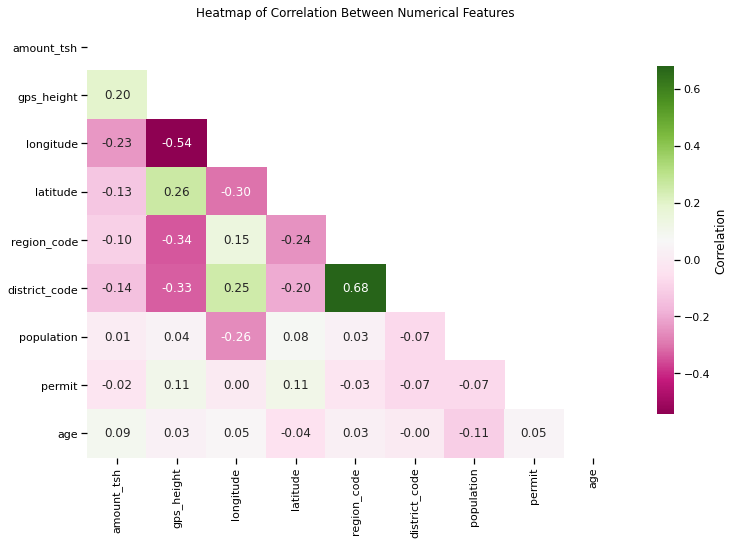

In [125]:
#heatmap of correlation for numerical features
def plot_numerical_correlation_heatmap(data):
   
    numerical_data = data.select_dtypes(include=['float64', 'int64'])
    
    # Calculate the correlation matrix
    corr_matrix = numerical_data.corr()
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="PiYG",
        mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),
        cbar_kws={"shrink": 0.8, "label": "Correlation"}
    )
    ax.set_title("Heatmap of Correlation Between Numerical Features")
    plt.show()

plot_numerical_correlation_heatmap(X_train)

In [126]:
import sklearn
print(sklearn.__version__)


0.23.2


In [192]:
# Check for NaN values in X_train_encoded
print("Missing values in X_train_encoded:")
print(X_train_encoded.isnull().sum())


Missing values in X_train_encoded:
funder_Danida                    0
funder_Government Of Tanzania    0
funder_Hesawa                    0
funder_Rwssp                     0
funder_other                     0
                                ..
region_code                      0
district_code                    0
population                       0
permit                           0
age                              0
Length: 74, dtype: int64


In [193]:
# Check for NaN or invalid values in y_train
print("Missing or invalid values in y_train:")
print(y_train.isnull().sum())

Missing or invalid values in y_train:
0


In [194]:
# Check for infinite values in X_train_encoded
print("Are there infinite values in X_train_encoded?")
print(np.isinf(X_train_encoded).sum())

Are there infinite values in X_train_encoded?
funder_Danida                    0
funder_Government Of Tanzania    0
funder_Hesawa                    0
funder_Rwssp                     0
funder_other                     0
                                ..
region_code                      0
district_code                    0
population                       0
permit                           0
age                              0
Length: 74, dtype: int64


## Modelling

In [197]:

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

print("Resampling completed successfully!")

print("Class distribution after SMOTE:", Counter(y_train_resampled))


Resampling completed successfully!
Class distribution after SMOTE: Counter({'functional': 25802, 'non functional': 25802, 'functional needs repair': 25802})


In [ ]:

# Function to evaluate a model and print results
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Trains and evaluates a model, printing classification reports and accuracy.
    """
    print(f"--- {model_name} ---")
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)

  
    # Generate and print the confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Print evaluation metrics
    print('\nClassification Report:')
    print(classification_report(y_val, y_pred))
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}\n")

    
    return model





#### Logistic Regression

In [ ]:
# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
evaluate_model(logistic_model, X_train_encoded, y_train, X_val_encoded, y_val, "Logistic Regression")

--- Logistic Regression ---


/home/edu/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Confusion Matrix:
[[5840   17  600]
 [ 673   21  157]
 [1744   21 2807]]

Classification Report:
                         precision    recall  f1-score   support

             functional       0.71      0.90      0.79      6457
functional needs repair       0.36      0.02      0.05       851
         non functional       0.79      0.61      0.69      4572

               accuracy                           0.73     11880
              macro avg       0.62      0.51      0.51     11880
           weighted avg       0.71      0.73      0.70     11880

Accuracy: 0.7296



,Model,Train Accuracy (%),Validation Accuracy (%)


#### Decision Tree

In [ ]:
# Decision Tree
decision_tree_model = DecisionTreeClassifier(random_state=42)
evaluate_model(decision_tree_model, X_train_encoded, y_train, X_val_encoded, y_val, "Decision Tree")

--- Decision Tree ---

Confusion Matrix:
[[5193  406  858]
 [ 382  337  132]
 [ 904  188 3480]]

Classification Report:
                         precision    recall  f1-score   support

             functional       0.80      0.80      0.80      6457
functional needs repair       0.36      0.40      0.38       851
         non functional       0.78      0.76      0.77      4572

               accuracy                           0.76     11880
              macro avg       0.65      0.65      0.65     11880
           weighted avg       0.76      0.76      0.76     11880

Accuracy: 0.7584



,Model,Train Accuracy (%),Validation Accuracy (%)


#### Random Forest

In [ ]:
# Random Forest
random_forest_model = RandomForestClassifier(random_state=42)
evaluate_model(random_forest_model, X_train_encoded, y_train, X_val_encoded, y_val, "Random Forest")

--- Random Forest ---

Confusion Matrix:
[[5644  201  612]
 [ 440  299  112]
 [ 906   91 3575]]

Classification Report:
                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      6457
functional needs repair       0.51      0.35      0.41       851
         non functional       0.83      0.78      0.81      4572

               accuracy                           0.80     11880
              macro avg       0.71      0.67      0.69     11880
           weighted avg       0.80      0.80      0.80     11880

Accuracy: 0.8012



RandomForestClassifier(random_state=42)

In [ ]:
def evaluate_models(models, X_train, y_train, X_val, y_val):

    results = []

    for name, model in models.items():
        # Predict on train and validation sets
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        # Calculate accuracy for train and validation sets
        train_acc = accuracy_score(y_train, train_pred) * 100
        val_acc = accuracy_score(y_val, val_pred) * 100

        # Append results
        results.append({
            'Model': name,
            'Train Accuracy (%)': round(train_acc, 2),
            'Validation Accuracy (%)': round(val_acc, 2)
        })

    summary_df = pd.DataFrame(results)
    return summary_df

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": decision_tree_model,
    "Random Forest": random_forest_model,
    "Tuned Random Forest": best_rf_model 
   
}

# Evaluate models and display results
summary_table = evaluate_models(models, X_train_encoded, y_train, X_val_encoded, y_val)
summary_table

The models chosen to be tuned further are the Random Forest Classifier and XGboost Classifier model. Its baseline performs better across the board in all scores.

In [59]:

# Tuned Random Forest (hyperparameter optimization)
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("--- Random Forest with Hyperparameter Tuning ---")
grid_search.fit(X_train_encoded, y_train)
best_rf_model = grid_search.best_estimator_

--- Random Forest with Hyperparameter Tuning ---
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 14.5min finished


In [225]:
# Evaluate the best model
evaluate_model(best_rf_model, X_train_encoded, y_train, X_val_encoded, y_val, "Tuned Random Forest")

# Display best parameters
print("\nTuned Random Forest Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
    
summary_table

--- Tuned Random Forest ---

Confusion Matrix:
[[5912  119  426]
 [ 496  248  107]
 [1070   56 3446]]

Classification Report:
                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      6457
functional needs repair       0.59      0.29      0.39       851
         non functional       0.87      0.75      0.81      4572

               accuracy                           0.81     11880
              macro avg       0.75      0.65      0.68     11880
           weighted avg       0.80      0.81      0.80     11880

Accuracy: 0.8086


Tuned Random Forest Best Hyperparameters:
max_depth: 20
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 500


,Model,Train Accuracy (%),Validation Accuracy (%)
0,Logistic Regression,72.99,72.96
1,Decision Tree,99.41,75.56
2,Random Forest,99.32,80.17
3,Tuned Random Forest,92.92,80.64


## Preprocessing Test Values Data


**The function used to preprocess the training data were called used to preprocess the test values** 

In [237]:
def clean_test_values(data):
    # Preprocess the test data as before
    data = irrelevant_columns(data, irrelevant_columns1)
    data = replace_placeholders_with_median(data)
    data = reduce_high_cardinality(data, 'funder', top_n=4)
    data = reduce_high_cardinality(data, 'installer', top_n=4)
    data = impute_missing_random(data, 'permit')
    data = replace_similar_values(data)
    boolean_columns = ['permit']
    encoder = OrdinalEncoder()
    data[boolean_columns] = encoder.fit_transform(data[boolean_columns].astype(str))
    data = add_age_column(data)
    data = handle_outliers(data, ['amount_tsh', 'gps_height', 'population'])
    data = drop_irrelevant_columns(data, irrelevant_columns2)

    # One-hot encoding for test data
    cat_cols = [col for col in data.columns if data[col].dtype == 'object']
    cont_cols = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]
    
    one_hot_encoding = ColumnTransformer(
        transformers=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)],
        remainder='passthrough'
    )

    ohe_pipe = Pipeline(steps=[('one_hot_encoding', one_hot_encoding)])
    data_encoded = ohe_pipe.fit_transform(data)

    # Extract encoded feature names for categorical columns
    encoder = one_hot_encoding.named_transformers_["ohe"]
    category_labels = encoder.get_feature_names(input_features=cat_cols)
    final_columns = list(np.append(category_labels, cont_cols))

    # Align test data with training columns
    test_data = pd.DataFrame(data_encoded, columns=final_columns, index=data.index)
    for col in cols:
        if col not in test_data.columns:
            test_data[col] = 0
    test_data = test_data[cols]

    return test_data

In [238]:
# Preprocess the test dataset
processed_test_set_values = clean_test_values(test_values)

# Display the processed dataset
print("Processed Test Set Shape:", processed_test_set_values.shape)
print(processed_test_set_values.head())
processed_test_set_values

Processed Test Set Shape: (14850, 74)
   funder_Danida  funder_Government Of Tanzania  funder_Hesawa  funder_Rwssp  \
0            0.0                            0.0            0.0             0   
1            0.0                            1.0            0.0             0   
2            0.0                            0.0            0.0             0   
3            0.0                            0.0            0.0             0   
4            0.0                            0.0            0.0             0   

   funder_other  installer_Commu  installer_DWE  installer_Government  \
0           1.0              0.0            0.0                   0.0   
1           0.0              0.0            1.0                   0.0   
2           1.0              0.0            0.0                   0.0   
3           1.0              0.0            0.0                   0.0   
4           1.0              0.0            0.0                   0.0   

   installer_RWE  installer_other  ...  wa

,funder_Danida,funder_Government Of Tanzania,funder_Hesawa,funder_Rwssp,funder_other,installer_Commu,installer_DWE,installer_Government,installer_RWE,installer_other,...,waterpoint_type_other,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,permit,age
0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,5.525453,7.599401,35.290799,-4.059696,21.0,3.0,5.774552,1.0,1.0
1,0.0,1.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,5.525453,7.358831,36.656709,-3.309214,2.0,2.0,5.707110,1.0,13.0
2,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,5.525453,7.357556,34.767863,-5.004344,13.0,2.0,6.216606,1.0,3.0
3,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,5.525453,5.590987,38.058046,-9.418672,80.0,43.0,5.525453,1.0,26.0
4,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,6.216606,7.139660,35.006123,-10.950412,10.0,3.0,4.110874,1.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.525453,3.555348,38.852669,-6.582841,6.0,1.0,3.044522,1.0,23.0
14846,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,6.908755,7.061334,37.451633,-5.350428,4.0,7.0,7.601912,0.0,17.0
14847,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.525453,7.297768,34.739804,-4.585587,13.0,2.0,5.303305,1.0,3.0
14848,0.0,0.0,0.0,0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,5.525453,6.906755,35.432732,-10.584159,10.0,2.0,5.017280,1.0,4.0
